# Import libraries and dataframe

In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix
from scoring_functions import scoring_functions as f

# imp allows to reload the above function file when tinkering with it without kernel restart
import imp

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../project_data/complaints_processed.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['narrative'].isnull().sum()

10

## Clean up dataframe 

In [3]:
df = df.dropna()

In [5]:
df.tail()

,product,narrative
162416,debt_collection,name
162417,credit_card,name
162418,debt_collection,name
162419,credit_card,name
162420,credit_reporting,name


In [6]:
df.loc[df['narrative'] == 'name']

,product,narrative
162415,debt_collection,name
162416,debt_collection,name
162417,credit_card,name
162418,debt_collection,name
162419,credit_card,name
162420,credit_reporting,name


In [7]:
df.shape

(162411, 2)

In [7]:
df.drop(df.loc[df['narrative'] == 'name'].index, inplace=True)
df.shape

(162405, 2)

In [9]:
df.tail()

,product,narrative
162410,credit_reporting,zales comenity bank closed sold account report...
162411,retail_banking,zelle suspended account without cause banking ...
162412,debt_collection,zero contact made debt supposedly resolved fou...
162413,mortgages_and_loans,zillow home loan nmls nmls actual quote provid...
162414,debt_collection,zuntafi sent notice willing settle defaulted s...


## Change product names to integers

In [8]:
df['product'].unique()

array(['credit_card', 'retail_banking', 'credit_reporting',
       'mortgages_and_loans', 'debt_collection'], dtype=object)

In [9]:
product_dict ={'credit_reporting': 0, 'debt_collection': 1, 'mortgages_and_loans': 2, 
               'credit_card': 3, 'retail_banking': 4}

In [10]:
df['product'].replace(product_dict, inplace=True)

In [11]:
df['product'].unique()

array([3, 4, 0, 2, 1], dtype=int64)

# Train-test split

In [12]:
X = df.drop(['product'], axis=1)
y = df['product']

X_train, X_test, y_train, y_test = train_test_split(X['narrative'], y, test_size=0.20, random_state=200)

In [15]:
X_train.shape

(129924,)

In [15]:
X_test.shape

(32481,)

In [16]:
y_train.head()

6530      3
88496     3
156067    0
69566     2
123950    2
Name: product, dtype: int64

In [17]:
y_train.shape

(129924,)

# TF-IDF

## Instatiate training set

For TF-IDF, do `fit_transform` on _X\_train_ only. Do not involve _y\_train_ because it doesn't involve the words, just the classes.

In [18]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2))
# vect_X_train = vectorizer.fit_transform(X_train)
# feature_names =  vectorizer.get_feature_names()

In [19]:
# vect_X_train

In [20]:
# len(feature_names)

In [21]:
# vect_X_train.shape

In [22]:
# vect_X_train.todense()

Don't have the memory to get it `todense()`

I don't think I'll need that many feature names (1700000). Going forward, I'll cut it down to 1000000 which is 58%

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000000)
vect_X_train = vectorizer.fit_transform(X_train)
feature_names =  vectorizer.get_feature_names()

In [17]:
len(feature_names)

1000000

In [18]:
vect_X_train.shape

(129924, 1000000)

Use `fit_transform()` on training data and `transform()` on test data. The model has already been fit on the training data, so you don't want to fit it again.

In [14]:
vect_X_test = vectorizer.transform(X_test)

# Create first model

## Create Naive Bayes model and predict

Instantiate new model instance. Fit the model to all the training data.

In [35]:
cls = MultinomialNB()
cls.fit(vect_X_train, y_train)

MultinomialNB()

Now that the model has been trained on the vectorized training data, see how it will predict classes from that test data. 

In [36]:
# y_pred = cls.predict(vect_X_test)
y_pred = cls.predict(vect_X_train)

In [37]:
np.unique(y_pred)

array([0, 1, 2, 3, 4], dtype=int64)

Compare how accurate the real test data is to what the model predicted

In [38]:
f'The accuracy score is: {round(accuracy_score(y_train, y_pred)*100, 2)}%'

'The accuracy score is: 72.02%'

Accuracy: 72.0%
Precision: 89.9%
Recall: 49.9%
F1: 58.0%


Classification Report


              precision    recall  f1-score   support

           0       0.67      1.00      0.80     73012
           1       0.96      0.23      0.37     18544
           2       0.97      0.54      0.70     15180
           3       0.94      0.25      0.40     12364
           4       0.96      0.48      0.64     10824

    accuracy                           0.72    129924
   macro avg       0.90      0.50      0.58    129924
weighted avg       0.80      0.72      0.68    129924



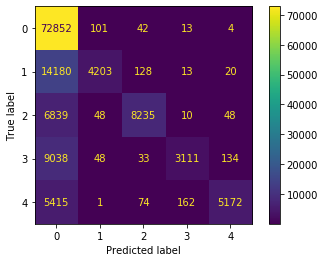

In [39]:
imp.reload(f)
f.scoring(y_train, y_pred, cls, vect_X_train)

## Check for overfitting

In [40]:
test_y_pred = cls.predict(vect_X_test)

In [41]:
f'The accuracy score is: {round(accuracy_score(y_test, test_y_pred)*100, 2)}%'

'The accuracy score is: 66.75%'

In [42]:
recall_scr = round(recall_score(y_test, test_y_pred, average='macro'), 2) * 100
f'The recall score is {recall_scr}%'

'The recall score is 41.0%'

Accuracy: 66.7%
Precision: 86.9%
Recall: 40.6%
F1: 46.8%


Classification Report


              precision    recall  f1-score   support

           0       0.63      1.00      0.77     18159
           1       0.91      0.14      0.25      4601
           2       0.96      0.40      0.56      3810
           3       0.91      0.15      0.26      3200
           4       0.94      0.34      0.50      2711

    accuracy                           0.67     32481
   macro avg       0.87      0.41      0.47     32481
weighted avg       0.76      0.67      0.60     32481



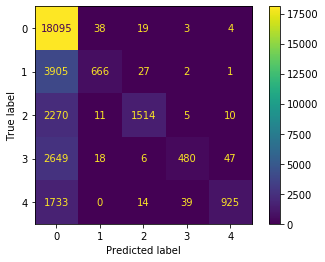

In [44]:
f.scoring(y_test, test_y_pred, cls, vect_X_test)

# Random Forest

In [15]:
rdmfst = RandomForestClassifier(max_depth=20)
rdmfst.fit(vect_X_train, y_train)

RandomForestClassifier(max_depth=20)

In [16]:
y_pred = rdmfst.predict(vect_X_train)

In [119]:
f'The accuracy score is: {round(accuracy_score(y_train, y_pred)*100, 2)}%'

'The accuracy score is: 57.87%'

Accuracy: 57.9%
Precision: 90.5%
Recall: 22.9%
F1: 20.1%


Classification Report


              precision    recall  f1-score   support

           0       0.57      1.00      0.73     73012
           1       0.98      0.04      0.08     18544
           2       0.98      0.06      0.12     15180
           3       0.99      0.01      0.02     12364
           4       1.00      0.03      0.06     10824

    accuracy                           0.58    129924
   macro avg       0.90      0.23      0.20    129924
weighted avg       0.75      0.58      0.44    129924



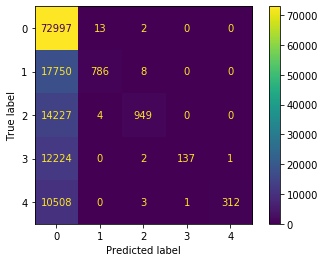

In [120]:
f.scoring(y_train, y_pred, rdmfst, vect_X_train)

In [17]:
test_y_pred = rdmfst.predict(vect_X_test)

In [122]:
f'The accuracy score is: {round(accuracy_score(y_test, test_y_pred)*100, 2)}%'

'The accuracy score is: 57.22%'

Accuracy: 57.1%
Precision: 86.8%
Recall: 22.1%
F1: 18.5%


Classification Report


              precision    recall  f1-score   support

           0       0.57      1.00      0.72     18159
           1       0.96      0.04      0.07      4601
           2       0.93      0.05      0.10      3810
           3       0.89      0.00      0.00      3200
           4       1.00      0.01      0.02      2711

    accuracy                           0.57     32481
   macro avg       0.87      0.22      0.18     32481
weighted avg       0.73      0.57      0.43     32481



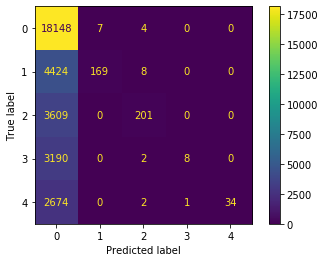

In [18]:
f.scoring(y_test, test_y_pred, rdmfst, vect_X_test)

# Decision Tree

In [28]:
dtree = DecisionTreeClassifier(max_depth=20)
dtree.fit(vect_X_train, y_train)

DecisionTreeClassifier(max_depth=20)

In [29]:
y_pred = dtree.predict(vect_X_train)
f'The accuracy score is: {round(accuracy_score(y_train, y_pred)*100, 2)}%'

'The accuracy score is: 89.68%'

Accuracy: 89.7%
Precision: 88.4%
Recall: 84.7%
F1: 86.4%


Classification Report


              precision    recall  f1-score   support

           0       0.91      0.96      0.94     73012
           1       0.87      0.77      0.82     18544
           2       0.91      0.83      0.87     15180
           3       0.83      0.82      0.83     12364
           4       0.91      0.84      0.87     10824

    accuracy                           0.90    129924
   macro avg       0.88      0.85      0.86    129924
weighted avg       0.90      0.90      0.90    129924



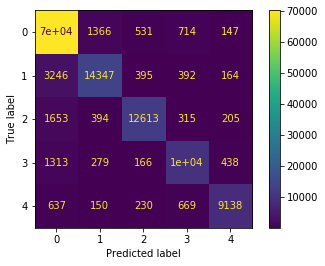

In [30]:
f.scoring(y_train, y_pred, dtree, vect_X_train)

In [31]:
test_y_pred = dtree.predict(vect_X_test)

In [32]:
f'The accuracy score is: {round(accuracy_score(y_test, test_y_pred)*100, 2)}%'

'The accuracy score is: 81.97%'

In [33]:
recall_scr = round(recall_score(y_test, test_y_pred, average='macro'), 2) * 100
f'The recall score is {recall_scr}%'

'The recall score is 74.0%'

Accuracy: 82.0%
Precision: 77.4%
Recall: 73.7%
F1: 75.4%


Classification Report


              precision    recall  f1-score   support

           0       0.87      0.92      0.89     18159
           1       0.74      0.65      0.69      4601
           2       0.80      0.72      0.76      3810
           3       0.69      0.66      0.67      3200
           4       0.78      0.73      0.75      2711

    accuracy                           0.82     32481
   macro avg       0.77      0.74      0.75     32481
weighted avg       0.82      0.82      0.82     32481



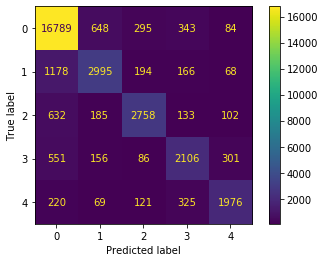

In [34]:
f.scoring(y_test, test_y_pred, dtree, vect_X_test)

# KNN

In [144]:
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')
neigh.fit(vect_X_train, y_train)

KNeighborsClassifier(weights='distance')

In [145]:
y_pred = neigh.predict(vectneightrain)
f'The accuracy score is: {round(accuracy_score(y_train, y_pred)*100, 2)}%'

'The accuracy score is: 99.54%'

Accuracy: 99.5%
Precision: 99.5%
Recall: 99.3%
F1: 99.4%


Classification Report


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     73012
           1       1.00      0.99      0.99     18544
           2       0.99      0.99      0.99     15180
           3       1.00      0.98      0.99     12364
           4       1.00      1.00      1.00     10824

    accuracy                           1.00    129924
   macro avg       1.00      0.99      0.99    129924
weighted avg       1.00      1.00      1.00    129924



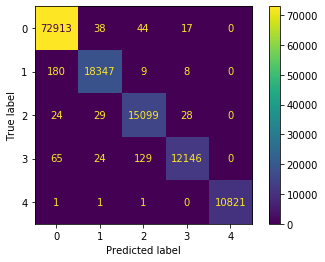

In [147]:
f.scoring(y_train, y_pred, neigh, vect_X_train)

In [148]:
test_y_pred = neigh.predict(vect_X_test)

In [149]:
f'The accuracy score is: {round(accuracy_score(y_test, test_y_pred)*100, 2)}%'

'The accuracy score is: 81.48%'

In [150]:
recall_scr = round(recall_score(y_test, test_y_pred, average='macro'), 2) * 100
f'The recall score is {recall_scr}%'

'The recall score is 70.0%'

Accuracy: 81.5%
Precision: 81.1%
Recall: 69.6%
F1: 74.2%


Classification Report


              precision    recall  f1-score   support

           0       0.82      0.97      0.88     18159
           1       0.86      0.59      0.70      4601
           2       0.83      0.62      0.71      3810
           3       0.76      0.58      0.66      3200
           4       0.79      0.72      0.76      2711

    accuracy                           0.81     32481
   macro avg       0.81      0.70      0.74     32481
weighted avg       0.82      0.81      0.81     32481



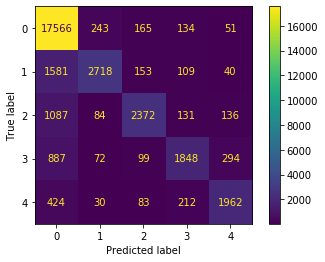

In [151]:
f.scoring(y_test, test_y_pred, neigh, vect_X_test)

# Gradient Boosting

In [155]:
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingClassifier
# hgboost = HistGradientBoostingClassifier(max_depth=20)
# hgboost.fit(vect_X_train.toarray(), y_train)


Histogram Gradient Boosting won't work, because it needs a dense array, which my machine can't handle.  
Trying normal Gradient Boosting...

In [20]:
gboost = GradientBoostingClassifier(max_depth=3)

In [21]:
gboost.fit(vect_X_train, y_train)

GradientBoostingClassifier()

In [22]:
y_pred = gboost.predict(vect_X_train)
f'The accuracy score is: {round(accuracy_score(y_train, y_pred)*100, 2)}%'

'The accuracy score is: 84.91%'

Accuracy: 84.9%
Precision: 83.3%
Recall: 78.5%
F1: 80.7%


Classification Report


              precision    recall  f1-score   support

           0       0.87      0.94      0.90     73012
           1       0.79      0.67      0.72     18544
           2       0.86      0.78      0.82     15180
           3       0.79      0.72      0.76     12364
           4       0.86      0.82      0.84     10824

    accuracy                           0.85    129924
   macro avg       0.83      0.78      0.81    129924
weighted avg       0.85      0.85      0.85    129924



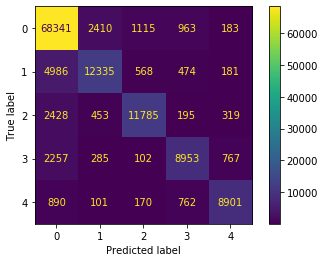

In [23]:
f.scoring(y_train, y_pred, gboost, vect_X_train)

In [24]:
test_y_pred = gboost.predict(vect_X_test)

In [25]:
f'The accuracy score is: {round(accuracy_score(y_test, test_y_pred)*100, 2)}%'

'The accuracy score is: 84.08%'

In [26]:
recall_scr = round(recall_score(y_test, test_y_pred, average='macro'), 2) * 100
f'The recall score is {recall_scr}%'

'The recall score is 77.0%'

Accuracy: 84.1%
Precision: 82.3%
Recall: 77.5%
F1: 79.7%


Classification Report


              precision    recall  f1-score   support

           0       0.86      0.93      0.89     18159
           1       0.78      0.66      0.72      4601
           2       0.84      0.77      0.80      3810
           3       0.79      0.70      0.74      3200
           4       0.85      0.81      0.83      2711

    accuracy                           0.84     32481
   macro avg       0.82      0.77      0.80     32481
weighted avg       0.84      0.84      0.84     32481



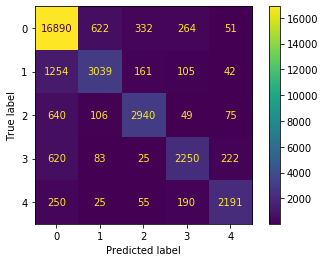

In [27]:
f.scoring(y_test, test_y_pred, gboost, vect_X_test)

# XGBoost

In [47]:
xgb = XGBClassifier()

In [48]:
xgb.fit(vect_X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [49]:
y_pred = xgb.predict(vect_X_train)
f'The accuracy score is: {round(accuracy_score(y_train, y_pred)*100, 2)}%'

'The accuracy score is: 83.28%'

Accuracy: 83.3%
Precision: 81.5%
Recall: 76.0%
F1: 78.5%


Classification Report


              precision    recall  f1-score   support

           0       0.85      0.93      0.89     73012
           1       0.78      0.64      0.70     18544
           2       0.84      0.76      0.80     15180
           3       0.77      0.68      0.72     12364
           4       0.84      0.79      0.82     10824

    accuracy                           0.83    129924
   macro avg       0.82      0.76      0.78    129924
weighted avg       0.83      0.83      0.83    129924



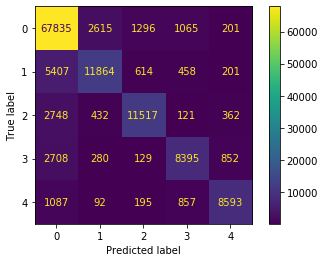

In [50]:
f.scoring(y_train, y_pred, xgb, vect_X_train)

In [51]:
test_y_pred = xgb.predict(vect_X_test)

In [52]:
f'The accuracy score is: {round(accuracy_score(y_test, test_y_pred)*100, 2)}%'

'The accuracy score is: 82.77%'

In [53]:
recall_scr = round(recall_score(y_test, test_y_pred, average='macro'), 2) * 100
f'The recall score is {recall_scr}%'

'The recall score is 76.0%'

Accuracy: 82.8%
Precision: 80.8%
Recall: 75.5%
F1: 77.9%


Classification Report


              precision    recall  f1-score   support

           0       0.85      0.92      0.88     18159
           1       0.76      0.64      0.70      4601
           2       0.83      0.76      0.79      3810
           3       0.78      0.67      0.72      3200
           4       0.83      0.78      0.80      2711

    accuracy                           0.83     32481
   macro avg       0.81      0.76      0.78     32481
weighted avg       0.82      0.83      0.82     32481



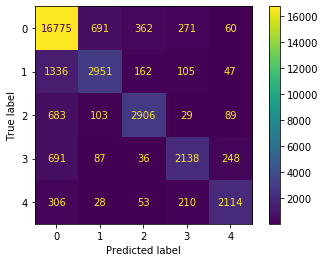

In [54]:
f.scoring(y_test, test_y_pred, xgb, vect_X_test)

# Comparing models

| model             | train accuracy | test accuracy | train recall macro | test recall macro | accuracy difference | recall macro difference | Notes                                                                                                                       |
|-------------------|----------------|---------------|--------------------|-------------------|---------------------|-------------------------|-----------------------------------------------------------------------------------------------------------------------------|
| MutlinomialNB     | 72             | 67            | 58                 | 47                | 5                   | 11                      | Many individual categories had poor recall. Model favors class with most data points. Any refinements would need weighting. |
| RandomForest      | 58             | 57            | 23                 | 22                | 1                   | 1                       | Well fitted, but not great performance. Model favors class with most data points.                                           |
| DecisionTree      | 90             | 82            | 85                 | 74                | 8                   | 11                      | Good recall with individual categories on train and test. Fitted OK.                                                        |
| KNN               | 100            | 81            | 99                 | 74                | 19                  | 25                      | Category recall scores not as good. Poor fit between train & test, class recall scores off. Model takes a long time to run. |
| Gradient Boosting | 85             | 84            | 81                 | 80                | 1                   | 1                       | Well fitted. Some classes have so-so recall comparisons. Takes long to run.                                                 |
| XGBoost           | 83             | 83            | 78                 | 78                | 0                   | 0                       | Very well fitted. Some classes have so-so recall.                                                                           |

**For Refinements**   

Gradient Boosting and XGBoost are similar, but Gradient Boosting is a little better. 

MultinomalNB might do better with SMOTE or `class_weight`. 

Decision Tree has the best accuracy. Might be worth seeing with refinements